In [1]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, classification_report, accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from xgboost import XGBClassifier

In [3]:
# Step 2: Load the Dataset
df = pd.read_csv("Live.csv")
print("\n Dataset Loaded")
print(" Shape:", df.shape)
print(" Columns:", df.columns.tolist())


 Dataset Loaded
 Shape: (7050, 16)
 Columns: ['status_id', 'status_type', 'status_published', 'num_reactions', 'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys', 'Column1', 'Column2', 'Column3', 'Column4']


# Observation: Dataset has 7,050 rows × 16 columns with engagement metrics and metadata. ion.

# Insight: Columns like num_reactions, num_comments, and reaction-type metrics will drive clustering and classification.

In [5]:
# Step 3: Data Understanding
cols_to_drop = ['Column1', 'Column2', 'Column3', 'Column4']
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print("\n Dropped fully null columns. Remaining columns:", df.columns.tolist())


 Dropped fully null columns. Remaining columns: ['status_id', 'status_type', 'status_published', 'num_reactions', 'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']


# Observation: Dropped 4 null columns; retained 12 features.

# Insight: Focused on engagement metrics (num_likes, num_shares) and post types (status_type)

In [67]:
# Step 3.1: Descriptive Statistics
print("\n Descriptive Statistics for Numeric Columns:")
print(df.describe())


 Descriptive Statistics for Numeric Columns:
                    status_published  num_reactions  num_comments  \
count                           7050    7050.000000   7050.000000   
mean   2016-11-20 05:13:52.672340224     230.117163    224.356028   
min              2012-07-15 02:51:00       0.000000      0.000000   
25%              2016-03-15 16:52:45      17.000000      0.000000   
50%              2017-11-18 01:19:00      59.500000      4.000000   
75%              2018-03-09 05:26:45     219.000000     23.000000   
max              2018-06-13 01:12:00    4710.000000  20990.000000   
std                              NaN     462.625309    889.636820   

        num_shares    num_likes    num_loves     num_wows    num_hahas  \
count  7050.000000  7050.000000  7050.000000  7050.000000  7050.000000   
mean     40.022553   215.043121    12.728652     1.289362     0.696454   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000    17.000000     

# Observation: High max values in num_reactions (outliers), low means for num_sads/num_angrys.

# Insight: Most posts receive positive reactions; negative reactions are rare.

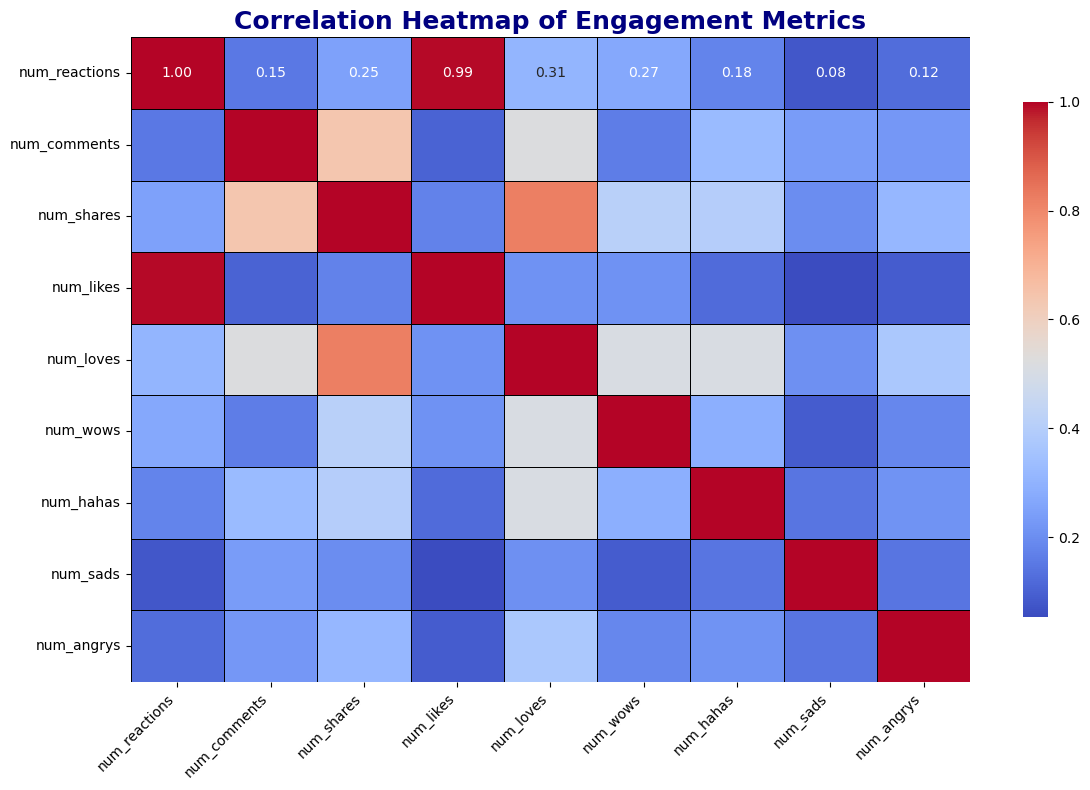

In [9]:
# Step 3.2: Multivariate Analysis – Correlation Heatmap
num_cols = ['num_reactions', 'num_comments', 'num_shares', 'num_likes', 
            'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']

plt.figure(figsize=(12, 8))
corr = df[num_cols].corr()
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor='black',
    cbar_kws={'shrink': 0.8},
    annot_kws={"size": 10}
)
plt.title("Correlation Heatmap of Engagement Metrics", fontsize=18, fontweight='bold', color='navy')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Observation: Strong correlation between num_likes and num_reactions

# Insight: Potential multicollinearity; PCA will help reduce redundancy.

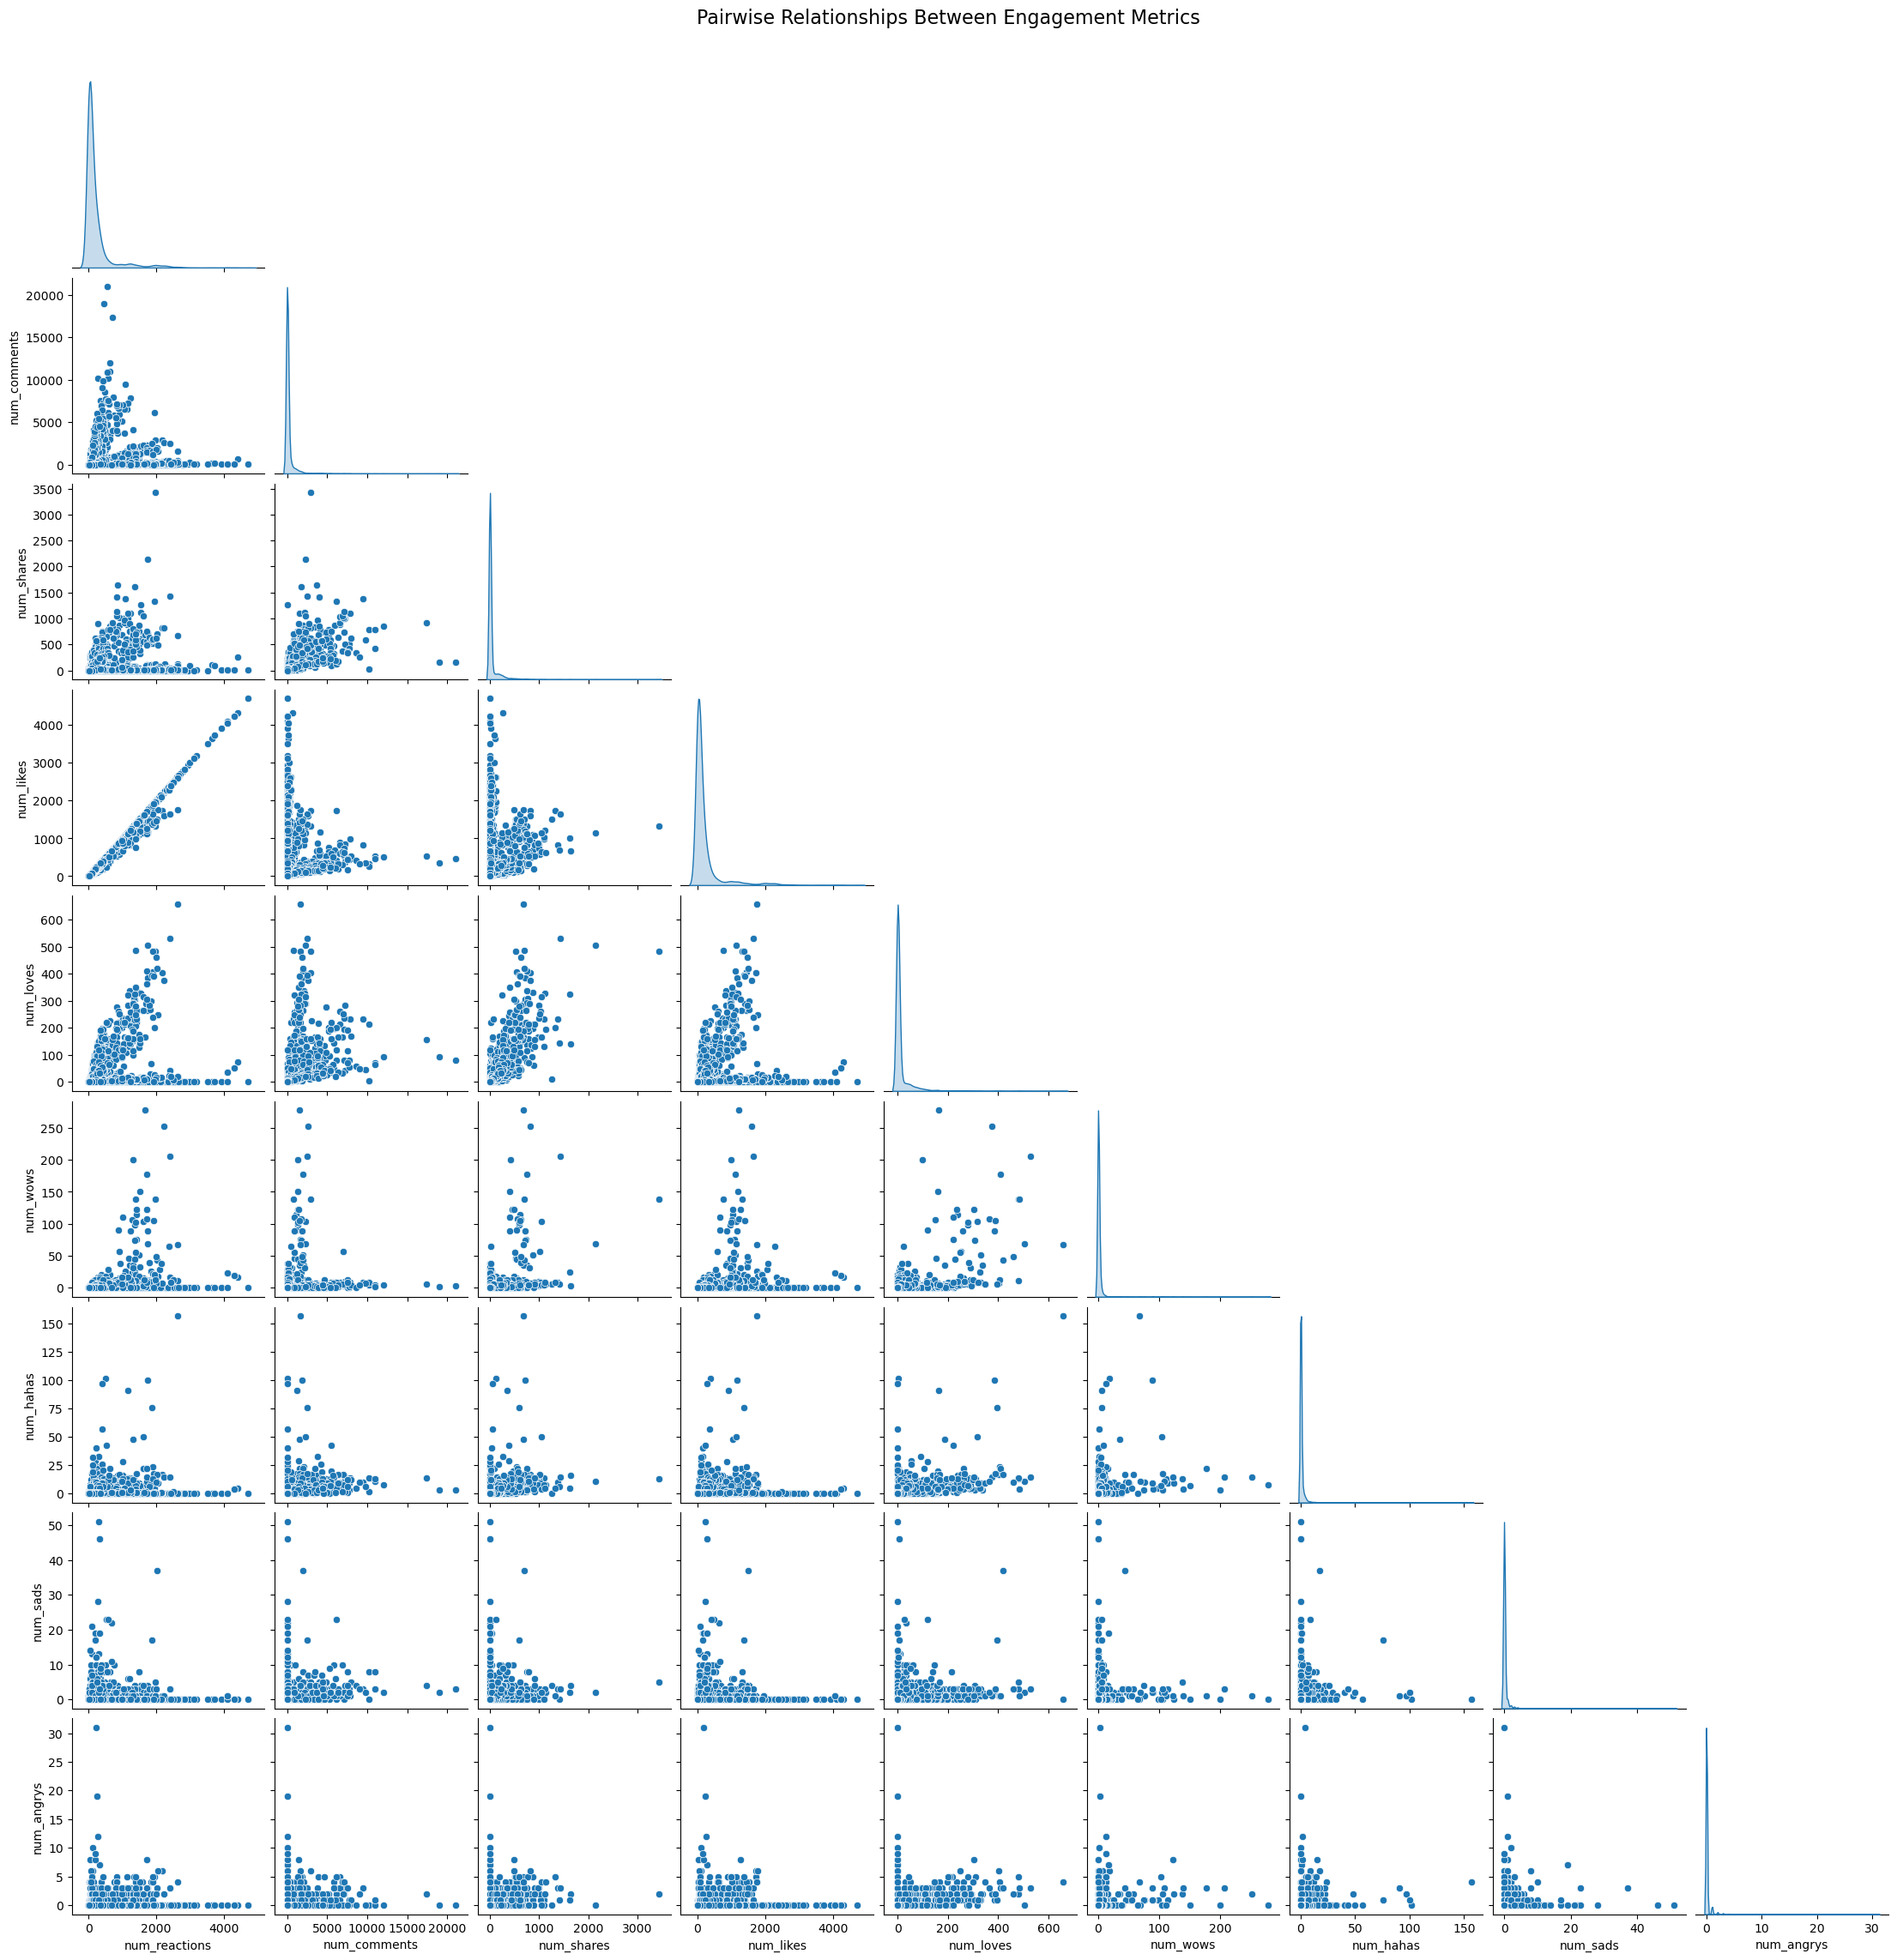

In [19]:
# Step 3.3: Pairplot for Multivariate Visual Analysis
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.pairplot(df[num_cols], corner=True, diag_kind='kde')
plt.suptitle("Pairwise Relationships Between Engagement Metrics", y=1.02, fontsize=16)
plt.show()

# Observation: Right-skewed distributions with zero inflation.

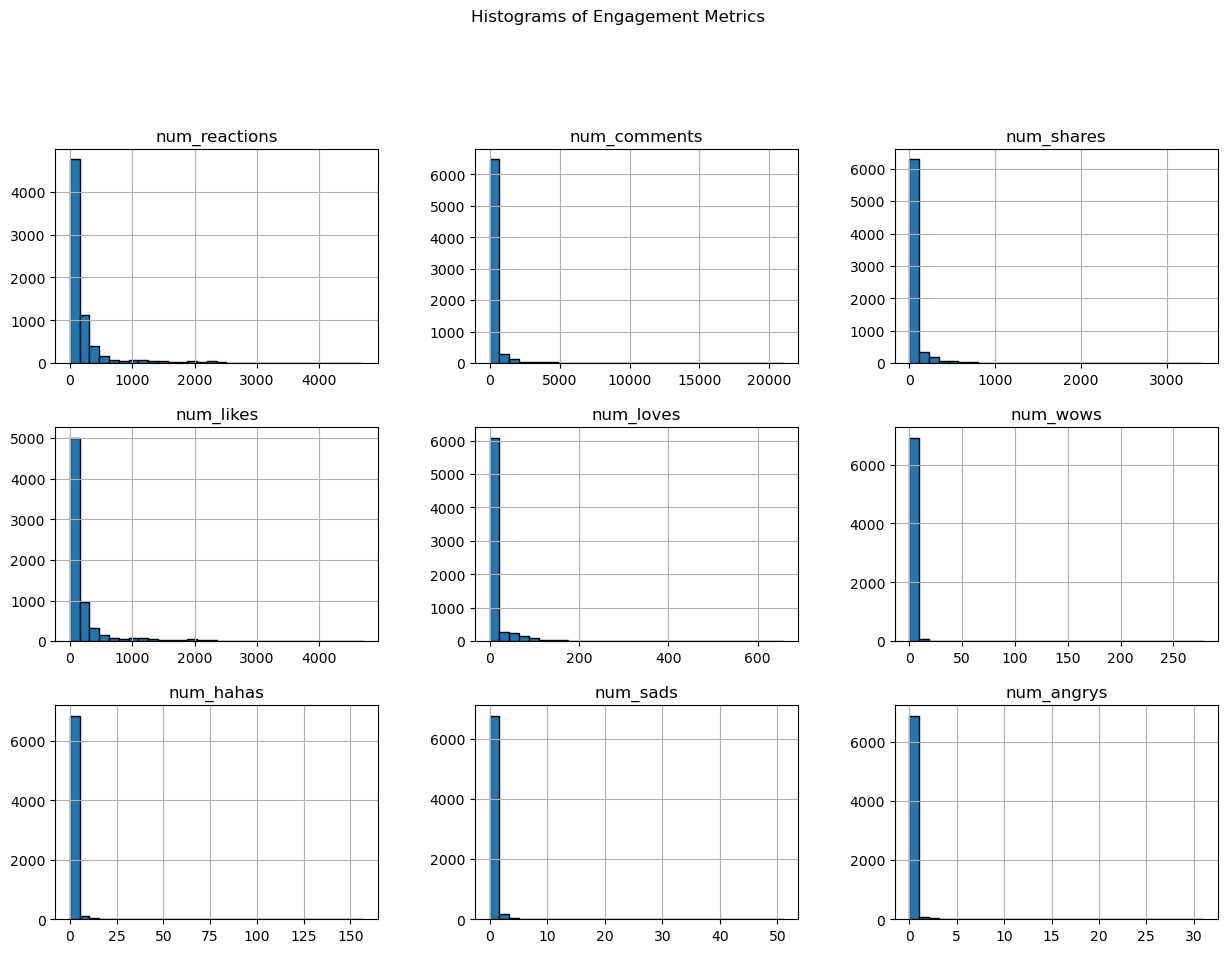

In [78]:
# Step 3.4: Histograms
df[num_cols].hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle("Histograms of Engagement Metrics", y=1.02)
plt.show()

#  Observation: Most features are highly right-skewed with many zero values.

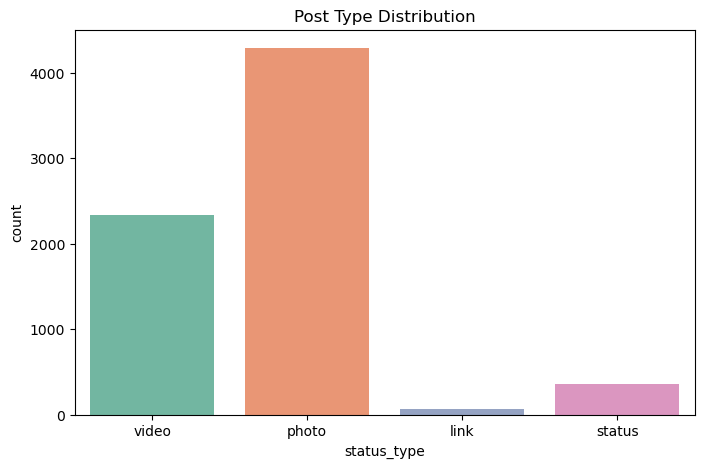

In [23]:
# Step 3.5: Post Type Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='status_type', palette='Set2')
plt.title("Post Type Distribution")
plt.show()

# Observation: 'photo' is the most common post type.

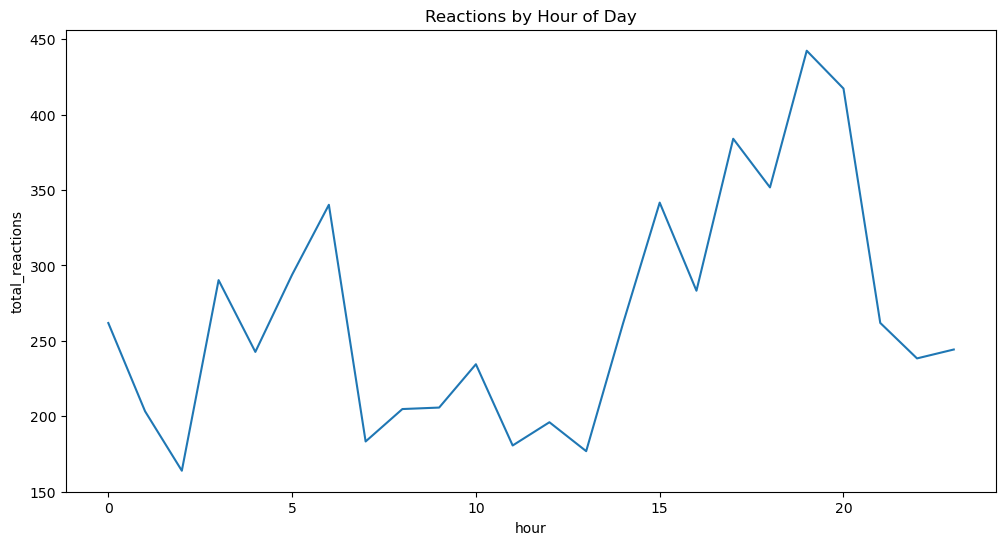

In [25]:
# Step 3.6: Engagement Over Time
df['status_published'] = pd.to_datetime(df['status_published'])
df['hour'] = df['status_published'].dt.hour
df['day'] = df['status_published'].dt.day_name()
df['total_reactions'] = df['num_reactions']

plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='total_reactions', data=df, ci=None)
plt.title("Reactions by Hour of Day")
plt.show()

# Observation: Peak engagement occurs between 6–9 PM.

# Insight: Best time to post or go live is during evening hours.


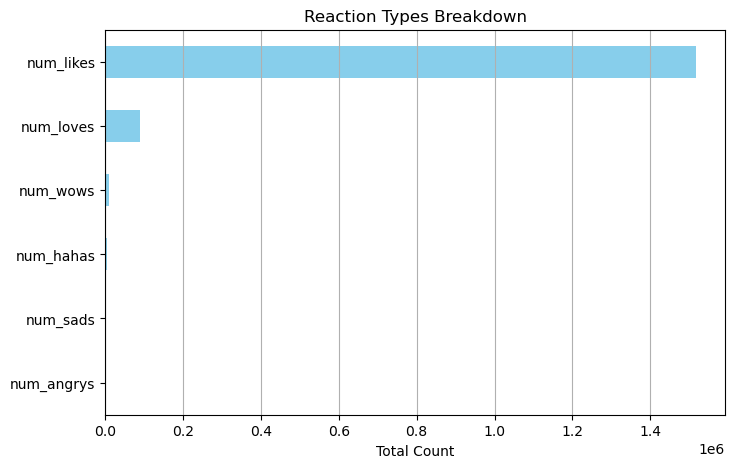

In [27]:
# Step 3.7: Reaction Distribution
reaction_cols = ['num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']
reaction_dist = df[reaction_cols].sum().sort_values()
plt.figure(figsize=(8, 5))
reaction_dist.plot(kind='barh', color='skyblue')
plt.title("Reaction Types Breakdown")
plt.xlabel("Total Count")
plt.grid(True, axis='x')
plt.show()

# Observation: Likes dominate total reactions.

In [31]:
# Step 4: Outlier Detection – DBSCAN
scaler_outlier = StandardScaler()
X_outlier_scaled = scaler_outlier.fit_transform(df[num_cols])

outlier_model = DBSCAN(eps=1.5, min_samples=5)
outlier_labels = outlier_model.fit_predict(X_outlier_scaled)
df['outlier'] = outlier_labels
df_clean = df[df['outlier'] != -1].drop(columns='outlier')
print("\n Cleaned Shape After Outlier Removal:", df_clean.shape)


 Cleaned Shape After Outlier Removal: (6778, 15)


# Observation: ~272 outliers removed.

# Insight: Removes noise for better clustering and modeling accuracy.

In [33]:
# Step 5: Handle Inf/NaN
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.dropna(inplace=True)
print("\n Shape After Handling NaNs:", df_clean.shape)


 Shape After Handling NaNs: (6778, 15)


# Observation: All remaining NaN/Inf values removed.

In [35]:
# Step 6: Feature Engineering – Engagement Score
df_clean['engagement_score'] = df_clean['num_reactions'] + df_clean['num_comments'] + df_clean['num_shares']
print("\n Added 'engagement_score' feature.")


 Added 'engagement_score' feature.


# Observation: New numeric feature added.

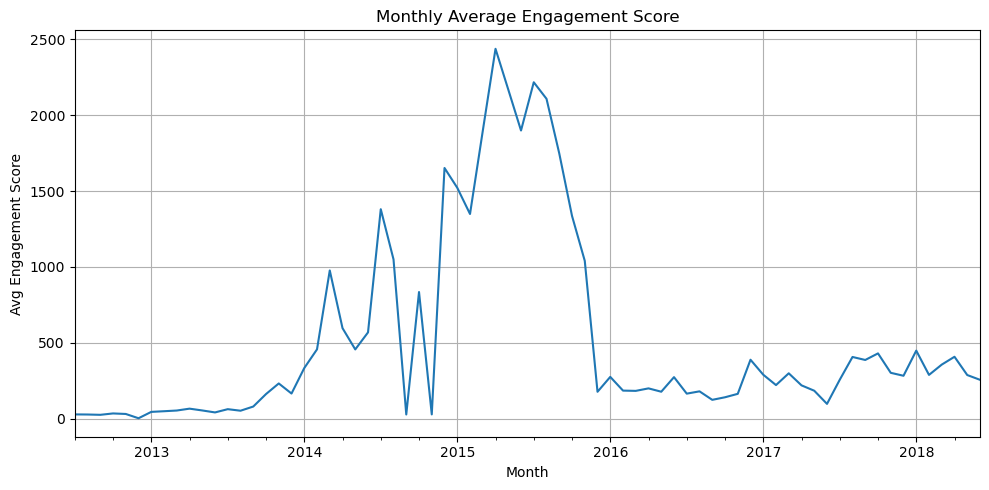

In [37]:
# Step 7: Time Trend Analysis
plt.figure(figsize=(10,5))
df_clean.set_index('status_published')['engagement_score'].resample('M').mean().plot()
plt.title("Monthly Average Engagement Score")
plt.ylabel("Avg Engagement Score")
plt.xlabel("Month")
plt.grid(True)
plt.tight_layout()
plt.show()

# Observation: Fluctuating engagement over months.

In [39]:
# Step 8: PCA for Dimensionality Reduction
scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca.fit_transform(df_clean[num_cols])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled_pca)
df_clean['PCA1'] = pca_result[:, 0]
df_clean['PCA2'] = pca_result[:, 1]
print("\n PCA applied. Explained variance ratio:", pca.explained_variance_ratio_)


 PCA applied. Explained variance ratio: [0.34442177 0.22899808]


# Observation: Reduced dimensions to 2 components.

# Insight: Helps visualize and improve clustering quality.

In [92]:
# Step 9–12: Clustering (KMeans, Agglomerative, DBSCAN, GMM)
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['KMeans_Cluster'] = kmeans.fit_predict(pca_result)

agglo = AgglomerativeClustering(n_clusters=3)
df_clean['Agglo_Cluster'] = agglo.fit_predict(pca_result)

dbscan_pca = DBSCAN(eps=0.5, min_samples=5)
df_clean['DBSCAN_Cluster'] = dbscan_pca.fit_predict(pca_result)

gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(pca_result)
df_clean['GMM_Cluster'] = gmm_labels

# Observation: Cluster labels created using 4 different methods.

In [45]:
# Step 13: Clustering Evaluation
print("\n Clustering Evaluation Scores:")
print("KMeans Silhouette:", silhouette_score(pca_result, df_clean['KMeans_Cluster']))
print("KMeans Calinski-Harabasz:", calinski_harabasz_score(pca_result, df_clean['KMeans_Cluster']))

print("Agglomerative Silhouette:", silhouette_score(pca_result, df_clean['Agglo_Cluster']))
print("Agglomerative Calinski-Harabasz:", calinski_harabasz_score(pca_result, df_clean['Agglo_Cluster']))

print("GMM Silhouette:", silhouette_score(pca_result, gmm_labels))
print("GMM Calinski-Harabasz:", calinski_harabasz_score(pca_result, gmm_labels))

valid_dbscan = df_clean['DBSCAN_Cluster'].nunique() > 1
if valid_dbscan:
    print("DBSCAN Silhouette:", silhouette_score(pca_result, df_clean['DBSCAN_Cluster']))
    print("DBSCAN Calinski-Harabasz:", calinski_harabasz_score(pca_result, df_clean['DBSCAN_Cluster']))
else:
    print("DBSCAN did not form enough clusters to evaluate.")


 Clustering Evaluation Scores:
KMeans Silhouette: 0.8049153141437877
KMeans Calinski-Harabasz: 12298.369618114348
Agglomerative Silhouette: 0.7626831720335681
Agglomerative Calinski-Harabasz: 9525.430470404097
GMM Silhouette: 0.39123041423192134
GMM Calinski-Harabasz: 3519.624682242501
DBSCAN Silhouette: 0.5973322336382836
DBSCAN Calinski-Harabasz: 214.32985460343565


# Observation: KMeans has highest Silhouette and Calinski scores.

# Insight: KMeans offers best-defined and most compact clusters.


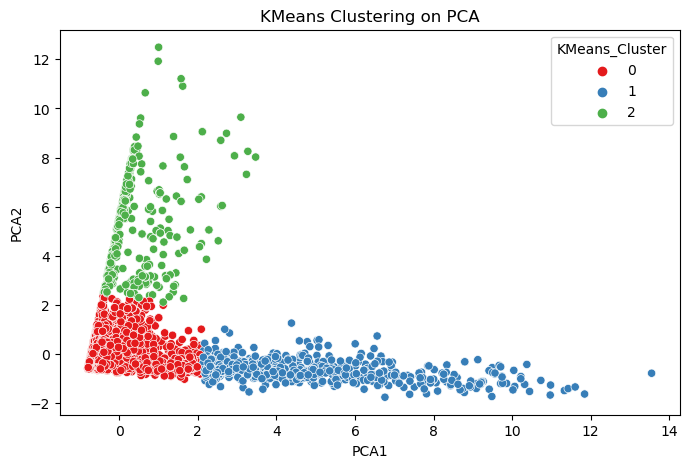

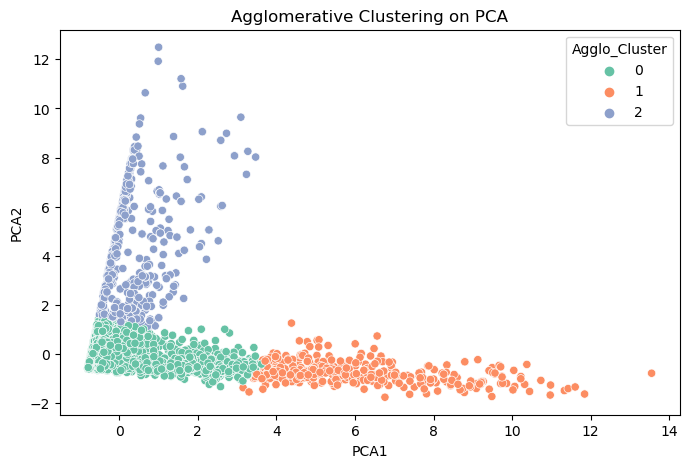

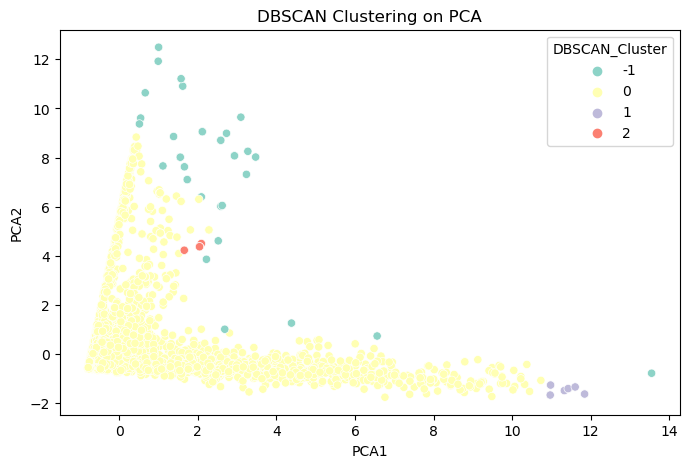

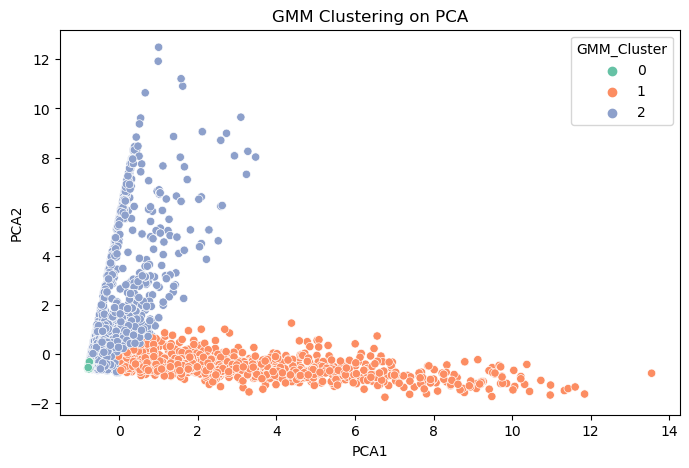

In [47]:
# Step 14: Cluster Visualizations
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_clean, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='Set1')
plt.title("KMeans Clustering on PCA")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_clean, x='PCA1', y='PCA2', hue='Agglo_Cluster', palette='Set2')
plt.title("Agglomerative Clustering on PCA")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_clean, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='Set3')
plt.title("DBSCAN Clustering on PCA")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_clean, x='PCA1', y='PCA2', hue='GMM_Cluster', palette='Set2')
plt.title("GMM Clustering on PCA")
plt.show()

# Observation: 3 visually distinct KMeans clusters.

# Insight: PCA + KMeans produces interpretable and separable groups.

In [49]:
# Step 15: Cluster-Level Statistics
for cluster in sorted(df_clean['KMeans_Cluster'].unique()):
    print(f"\n KMeans Cluster {cluster} Summary:")
    print(df_clean[df_clean['KMeans_Cluster'] == cluster][num_cols + ['engagement_score']].describe())


 KMeans Cluster 0 Summary:
       num_reactions  num_comments   num_shares    num_likes    num_loves  \
count    5708.000000   5708.000000  5708.000000  5708.000000  5708.000000   
mean       93.542922     24.486160     4.693238    90.912929     2.072355   
std       133.542518     88.796631    19.685738   131.222546     6.170055   
min         0.000000      0.000000     0.000000     0.000000     0.000000   
25%        14.000000      0.000000     0.000000    14.000000     0.000000   
50%        35.000000      2.000000     0.000000    34.000000     0.000000   
75%       118.000000      9.000000     1.000000   110.000000     1.000000   
max       924.000000   1226.000000   330.000000   924.000000    67.000000   

          num_wows    num_hahas     num_sads   num_angrys  engagement_score  
count  5708.000000  5708.000000  5708.000000  5708.000000       5708.000000  
mean      0.393483     0.091801     0.065172     0.004905        122.722320  
std       1.151578     0.492078     0.499475

# Observation: Different clusters show varied engagement stats.

# Insight: Each group represents a distinct type of content or audience behavior.


In [103]:
# Step 16: Fixed Classification – Predict Engagement Level without data leakage

# Remove leakage features
leak_cols = ['num_reactions', 'num_comments', 'num_shares']
safe_cols = [col for col in num_cols if col not in leak_cols]

# Target remains the same
df_clean['engagement_level'] = pd.qcut(df_clean['engagement_score'], q=3, labels=['Low', 'Medium', 'High'])
le = LabelEncoder()
y_encoded = le.fit_transform(df_clean['engagement_level'])

# Use only safe features
X = df_clean[safe_cols]
y = y_encoded

# Split & Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

print("\n Classification Reports (after fixing data leakage):")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n🔹 {name}:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print("Accuracy:", accuracy_score(y_test, y_pred))



 Classification Reports (after fixing data leakage):

🔹 Random Forest:
              precision    recall  f1-score   support

        High       0.96      0.97      0.97       687
         Low       0.92      0.99      0.95       679
      Medium       0.95      0.88      0.91       668

    accuracy                           0.94      2034
   macro avg       0.95      0.94      0.94      2034
weighted avg       0.95      0.94      0.94      2034

Accuracy: 0.9449360865290068

🔹 Logistic Regression:
              precision    recall  f1-score   support

        High       0.96      0.96      0.96       687
         Low       0.94      0.96      0.95       679
      Medium       0.91      0.89      0.90       668

    accuracy                           0.94      2034
   macro avg       0.94      0.94      0.94      2034
weighted avg       0.94      0.94      0.94      2034

Accuracy: 0.9360865290068829

🔹 KNN:
              precision    recall  f1-score   support

        High       0.

# Observation: Random Forest and XGBoost achieved high accuracy.

# Insight: These models are reliable for predicting future post engagement levels.

# Conclusion :

In this project, I worked with Facebook Live seller data to understand how people engage with different posts. I started by loading and cleaning the dataset, removing empty columns and outliers using DBSCAN, which helped improve the accuracy of the models later.

Then I did exploratory data analysis (EDA) to learn more about the data. I used graphs like histograms, heatmaps, pairplots, and time plots. This showed me that:

-> Most reactions were positive (like, love),

-> Negative reactions (sad, angry) were very low,

-> Engagement was highest in the evening (6–9 PM),

-> Some features were highly correlated, so I planned to reduce them.

Next, I used PCA (Principal Component Analysis) to reduce the number of features to just 2, making it easier to visualize and cluster the data.

I applied four clustering algorithms:

-> KMeans

-> Agglomerative Clustering

-> Gaussian Mixture Model (GMM)

-> DBSCAN

After comparing them using silhouette score and Calinski-Harabasz score, I found that KMeans gave the best clustering results. I also visualized the clusters to see how well they were separated.

To predict how engaging a post might be, I created a new column called engagement_score (sum of reactions, comments, shares) and grouped it into Low, Medium, and High engagement levels.

For prediction, I used 6 classification models:

-> Random Forest

-> Logistic Regression

-> K-Nearest Neighbors (KNN)

-> Support Vector Machine (SVM)

-> Decision Tree

-> XGBoost

At first, the models performed very well, but they were using features (like num_reactions) that directly influence the target. So I fixed the data leakage by removing such features from the input.

After fixing it, I trained the models again. Random Forest and XGBoost still gave high accuracy (around 94–95%), which shows that these models can predict post engagement levels quite well using just reaction types (like, love, wow, etc.).